# **Pytorch implementation of the linear neural network**

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

**Pytorch implementation of Linear**

Reference : [torch.nn.Linear]('https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear')

In [2]:
class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

**Pytorch implementation of BatchNorm1d**

Reference : [torch.nn.BatchNorm1d]('https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d')

In [3]:
class BatchNorm1d:
  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True)
      xvar = x.var(0, keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
        self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

**Pytorch implementation of Tanh**

Reference : [torch.nn.Tanh]('https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh')

In [4]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [5]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)
vocab_size

27

In [6]:
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [7]:
X,Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [8]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator = g)

layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

46497


In [9]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []
ud = []

for epoch in range(epochs + 1):
  if epoch > 50000:
    lr = 0.01

  # minibatch
  ix = torch.randint(0, X.shape[0], (batch_size,), generator = g)

  # forward pass
  emb = C[X[ix]]   # (batch_size, 2, 3)
  x = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Y[ix])

  for layer in layers:
    layer.out.retain_grad()

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if epoch  == 1000 :
    break


0 / 70000:  3.2809


layer 1 (      Tanh): mean -0.06, std 0.76, saturated: 21.28%
layer 3 (      Tanh): mean -0.03, std 0.72, saturated: 12.53%
layer 5 (      Tanh): mean +0.01, std 0.74, saturated: 14.38%
layer 7 (      Tanh): mean -0.02, std 0.73, saturated: 12.41%
layer 9 (      Tanh): mean -0.04, std 0.70, saturated: 9.25%


Text(0.5, 1.0, 'activation distribution')

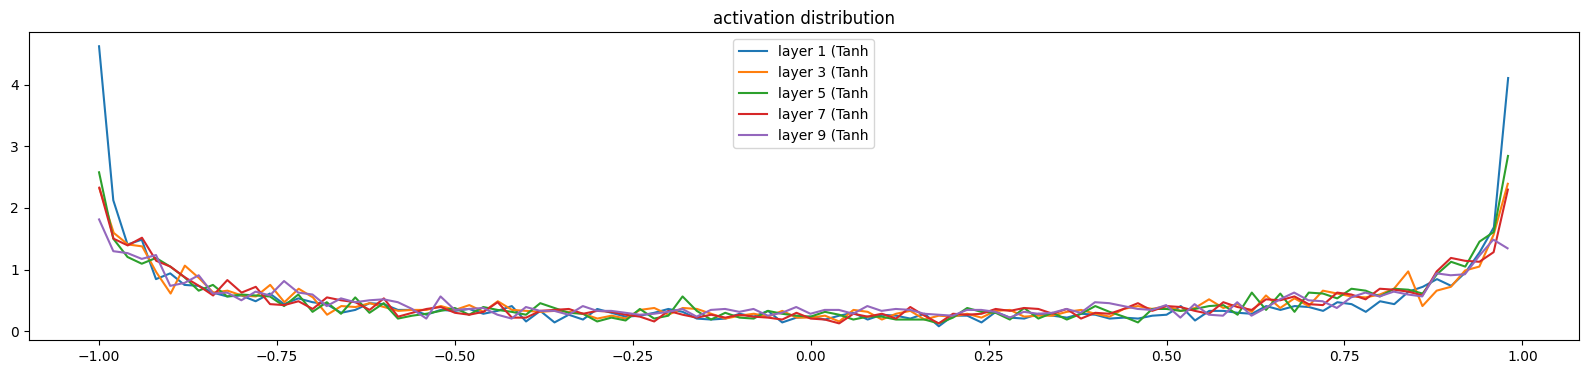

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000092, std 3.028595e-03
layer 3 (      Tanh): mean +0.000035, std 2.906687e-03
layer 5 (      Tanh): mean +0.000018, std 2.836356e-03
layer 7 (      Tanh): mean -0.000009, std 2.592615e-03
layer 9 (      Tanh): mean +0.000019, std 2.173709e-03


Text(0.5, 1.0, 'gradient distribution')

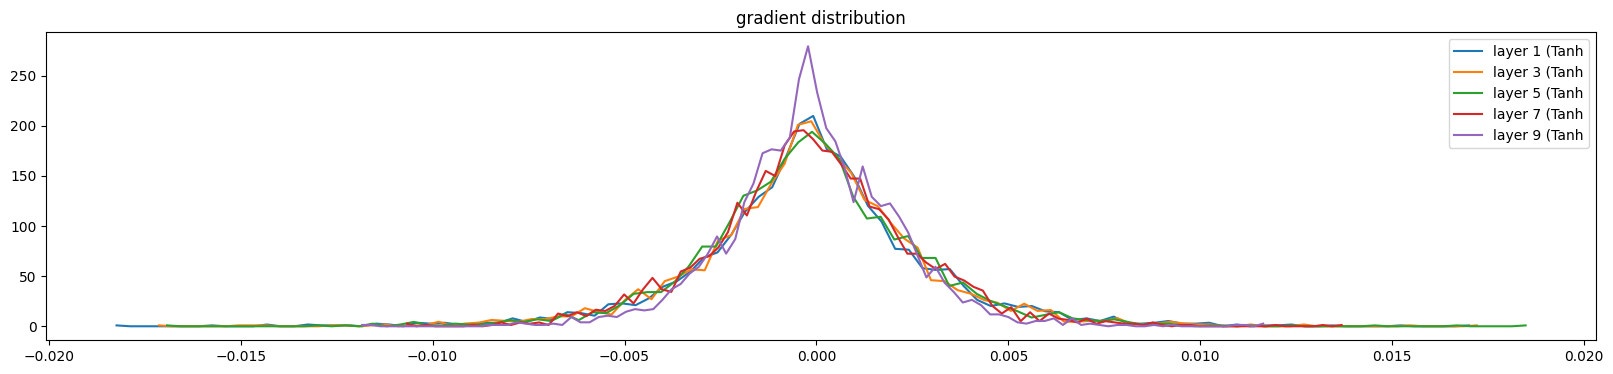

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.001354 | std 1.040982e-02 | grad:data ratio 1.040037e-02
weight  (30, 100) | mean +0.000101 | std 9.227335e-03 | grad:data ratio 2.943290e-02
weight (100, 100) | mean +0.000028 | std 7.101864e-03 | grad:data ratio 4.207149e-02
weight (100, 100) | mean +0.000056 | std 6.623027e-03 | grad:data ratio 3.893919e-02
weight (100, 100) | mean +0.000004 | std 6.027569e-03 | grad:data ratio 3.567651e-02
weight (100, 100) | mean +0.000008 | std 5.276481e-03 | grad:data ratio 3.137194e-02
weight  (100, 27) | mean +0.000000 | std 2.195243e-02 | grad:data ratio 3.041518e-01


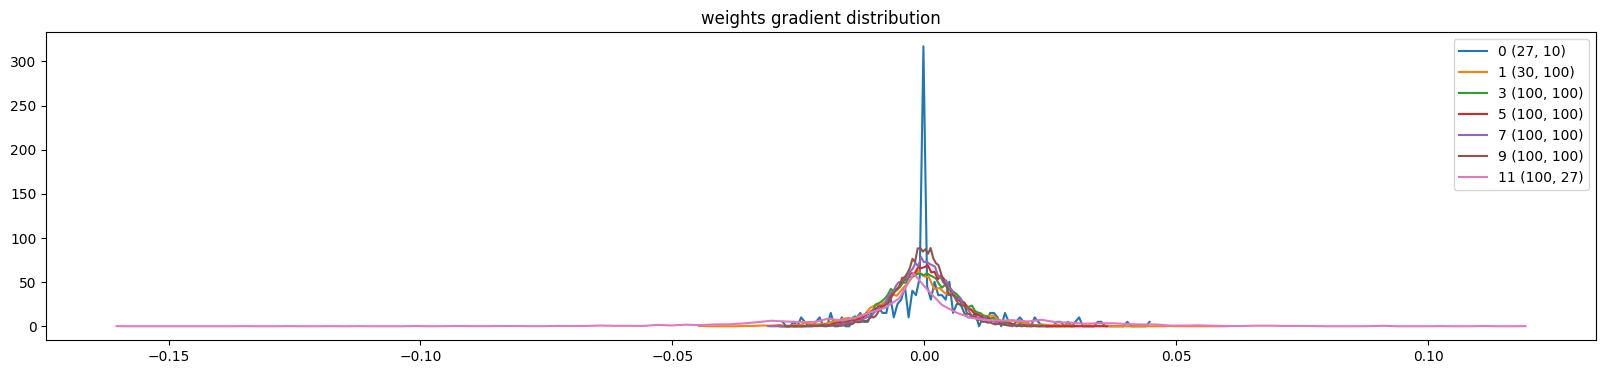

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

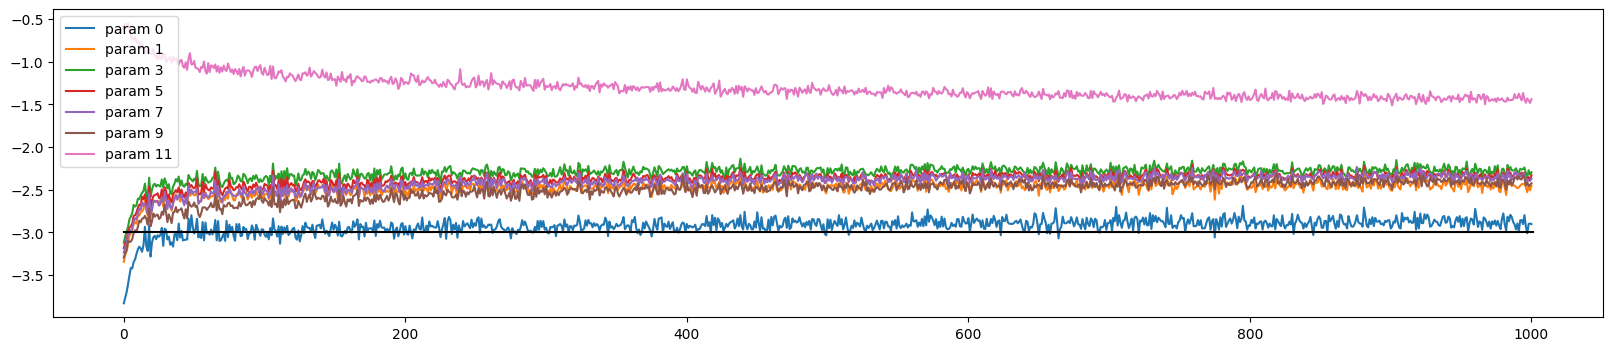

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### **With batch norm**

In [14]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator = g)

layers = [
    Linear(n_emb * block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),BatchNorm1d(vocab_size),
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

47551


In [15]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []
ud = []

for epoch in range(epochs + 1):
  if epoch > 50000:
    lr = 0.01

  # minibatch
  ix = torch.randint(0, X.shape[0], (batch_size,), generator = g)

  # forward pass
  emb = C[X[ix]]   # (batch_size, 2, 3)
  x = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Y[ix])

  for layer in layers:
    layer.out.retain_grad()

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


0 / 70000:  3.2655
10000 / 70000:  2.1489
20000 / 70000:  3.0059
30000 / 70000:  2.2245
40000 / 70000:  2.0012
50000 / 70000:  2.1280
60000 / 70000:  1.9908
70000 / 70000:  2.1878


layer 2 (      Tanh): mean +0.02, std 0.65, saturated: 11.16%
layer 5 (      Tanh): mean -0.02, std 0.70, saturated: 13.84%
layer 8 (      Tanh): mean +0.02, std 0.72, saturated: 11.88%
layer 11 (      Tanh): mean +0.01, std 0.75, saturated: 9.88%
layer 14 (      Tanh): mean -0.02, std 0.77, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

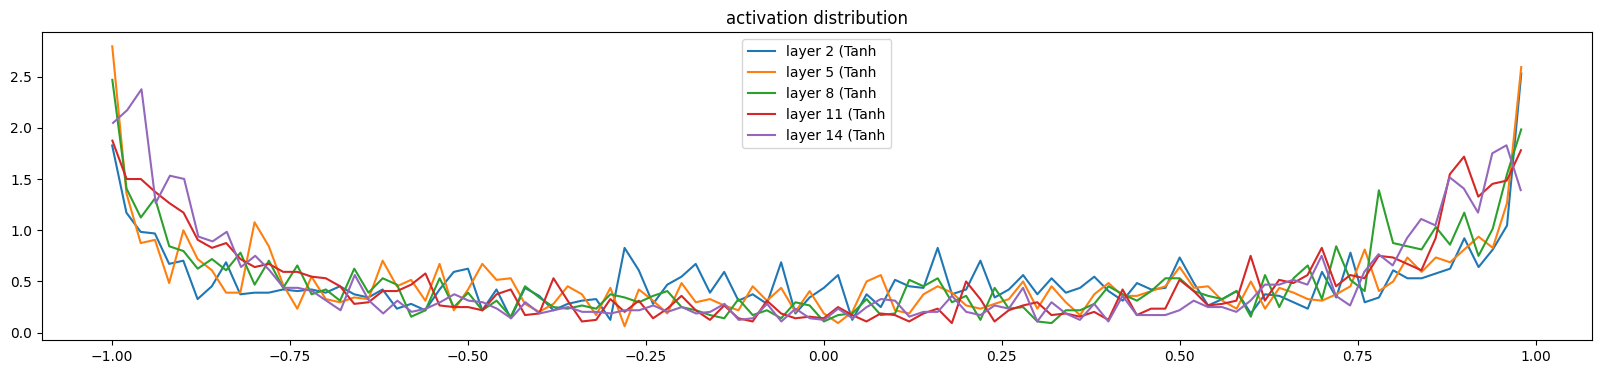

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.229911e-03
layer 5 (      Tanh): mean +0.000000, std 2.925972e-03
layer 8 (      Tanh): mean +0.000000, std 2.989741e-03
layer 11 (      Tanh): mean -0.000000, std 3.119538e-03
layer 14 (      Tanh): mean +0.000000, std 3.336686e-03


Text(0.5, 1.0, 'gradient distribution')

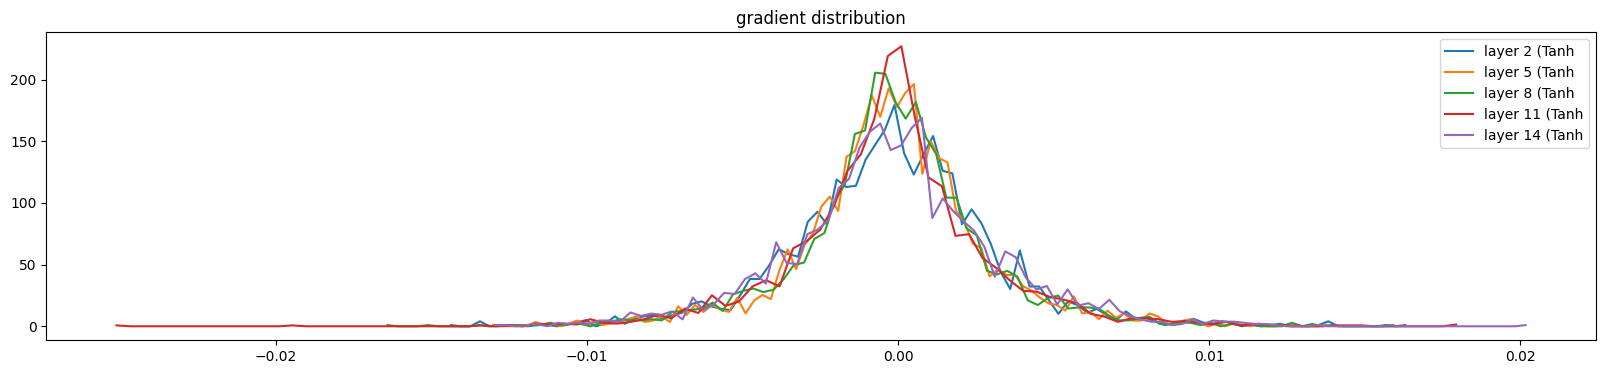

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.754146e-02 | grad:data ratio 1.665648e-02
weight  (30, 100) | mean -0.000222 | std 8.227942e-03 | grad:data ratio 2.191760e-02
weight (100, 100) | mean +0.000033 | std 5.101060e-03 | grad:data ratio 2.303173e-02
weight (100, 100) | mean +0.000023 | std 4.954400e-03 | grad:data ratio 2.271928e-02
weight (100, 100) | mean +0.000018 | std 5.046053e-03 | grad:data ratio 2.364897e-02
weight (100, 100) | mean -0.000032 | std 4.817826e-03 | grad:data ratio 2.316649e-02
weight  (100, 27) | mean +0.000139 | std 8.491366e-03 | grad:data ratio 2.961852e-02


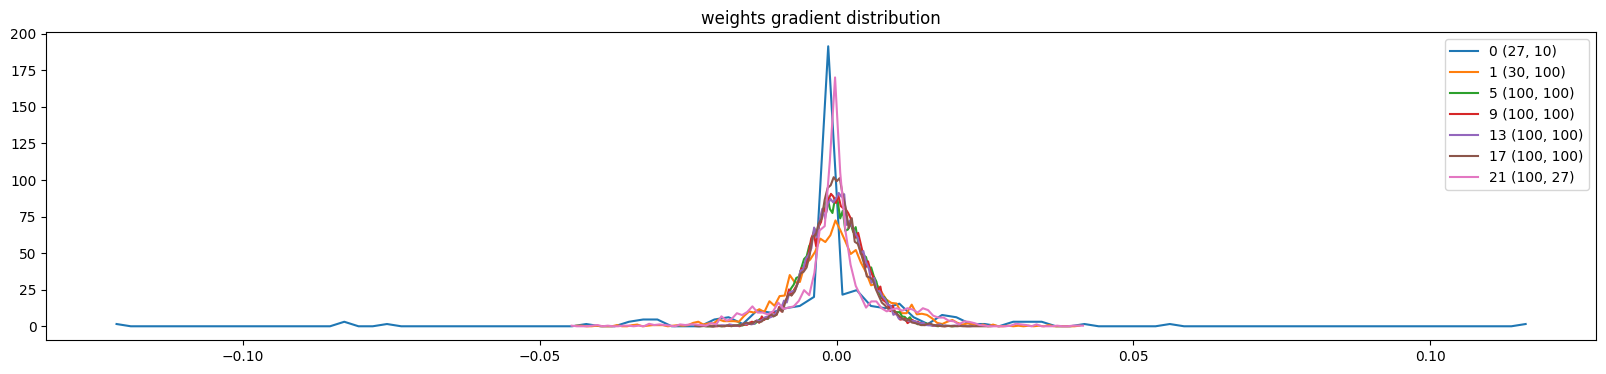

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

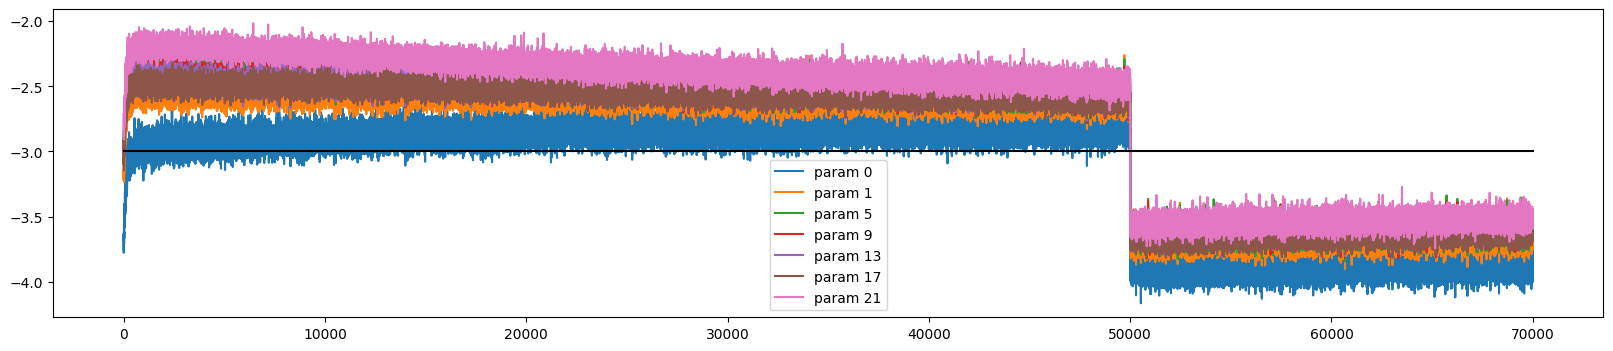

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(x, y):
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(f'Model loss : {loss.item() : .4f}')

# put layers into eval mode
for layer in layers:
  layer.training = False

split_loss(X, Y)

Model loss :  2.0629


In [21]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mon.
almyah.
seel.
ndhayla.
remmastendraegen.
ched.
elin.
shi.
jen.
eden.
van.
aaraelyn.
malaia.
noshubergahimiel.
kendreelynn.
novana.
uba.
geder.
yaruf.
els.
